In [1]:
import pandas as pd
from rdkit import rdBase, Chem, DataStructs
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem.AtomPairs import Pairs, Torsions
import pickle
from utils.algorithms import greedy_baseline
from evaluation.evaluation import cdf_wdud, dfs2wds, dfs2mpd
import numpy as np
import random   
import pickle 
print(rdBase.rdkitVersion)

single_tasks = ['qm9']
model_name = '_attentivefp_'
nums = ['_1', '_2', '_3', '_4', '_5']
properties = ['mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u298', 'h298', 'g298', 'cv', 'zpve/3n-6', 'u0/Nelec', 'u298/Nelec', 'h298/Nelec', 'g298/Nelec', 'cv/3n-6']
#properties = ['mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u298', 'h298', 'g298', 'cv', 'u0/Nelec', 'u298/Nelec', 'h298/Nelec', 'g298/Nelec', 'cv/3n-6', 'Nelec', 'Natom']

# load data
df = pickle.load(open("./save_pickle/result_df.p", "rb"))
# df = pickle.load(open("./save_pickle/in-domain-qm9.p", "rb"))

for num in nums:
    df['qm9'][num]['zpve/3n-6'] = df['qm9'][num]['mu']
    df['qm9_normalize'][num]['zpve/3n-6'] = df['qm9_normalize'][num]['mu']

n_mols = len(df['qm9']['_1'])
n_select = int(n_mols*0.01)


2020.09.1


# Caluculate Wasserstein Distances

In [2]:
# make new dataframe, wasserstein_distances.
wasserstein_distances = pd.DataFrame([])
gnn_based = ['logdet_ranking', 'maxsum_dissim_ranking', 'maxmin_dissim_ranking', 'random_ranking']
binary_based = ['maxsum_dissim_ranking_maccs', 'maxmin_dissim_ranking_maccs', 'maxsum_dissim_ranking_ecfp', 'maxmin_dissim_ranking_ecfp']

distances = dfs2wds(df['qm9'], gnn_based, n_select, properties)
wasserstein_distances = pd.concat([wasserstein_distances, distances])

distances = dfs2wds(df['qm9_normalize'], gnn_based, n_select, properties)
distances['method'] = distances['method'].apply(lambda x: x+'_normalize')
wasserstein_distances = pd.concat([wasserstein_distances, distances])

distances = dfs2wds(df['qm9'], binary_based, n_select, properties)
wasserstein_distances = pd.concat([wasserstein_distances, distances])

In [3]:
# add random mean values for rescaling
wasserstein_distances['random_average'] = 0
for prop in properties:
    random_average = wasserstein_distances[(wasserstein_distances['property'] == prop) & (wasserstein_distances['method'] == 'random_ranking')]['distance'].mean()
    wasserstein_distances.loc[wasserstein_distances['property'] == prop, 'random_average'] = random_average

wasserstein_distances['scaled_distance'] = wasserstein_distances['distance'] / wasserstein_distances['random_average']

In [4]:
# save wdud values
pickle.dump(wasserstein_distances, open( "./evaluation/wdud_values.p", "wb" ))

df_mean = wasserstein_distances.groupby(['method', 'property']).mean()
df_mean.to_csv("./evaluation/wdud_mean.csv")

df_std = wasserstein_distances.groupby(['method', 'property']).std()
df_std.to_csv("./evaluation/wdud_std.csv")

# Barplot Wasserstein Distances

In [26]:
from matplotlib import pyplot as plt 
import seaborn as sns
import pickle
import numpy as np
sns.set()

with open('./evaluation/wdud_values.p', 'rb') as f:
    wasserstein_distances = pickle.load(f)

main_method_labels = ['SUBMO-GNN', 'MS-MK', 'MM-MK', 'MS-EF', 'MM-EF', 'Random']
ablation_method_labels = ['SUBMO w/o N', 'SUBMO w/ N', 'MS w/o N', 'MS w/ N', 'MM w/o N', 'MM w/ N', 'Random']

<Figure size 432x288 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

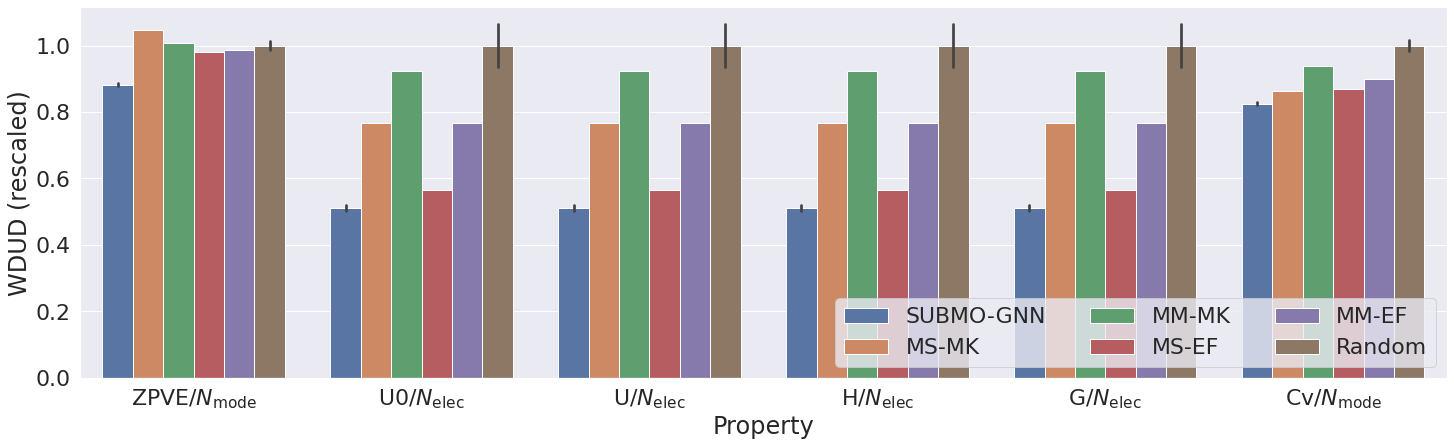

In [6]:
methods = ['logdet_ranking_normalize', 'maxsum_dissim_ranking_maccs', 'maxmin_dissim_ranking_maccs', 'maxsum_dissim_ranking_ecfp', 'maxmin_dissim_ranking_ecfp', 'random_ranking']
plotdf = wasserstein_distances[wasserstein_distances['method'].isin(methods)]

properties_lists = [
    ['mu', 'alpha', 'homo', 'lumo', 'gap', 'r2'],  
    ['zpve', 'u0', 'u298', 'h298', 'g298', 'cv'],  
    ['zpve/3n-6', 'u0/Nelec', 'u298/Nelec', 'h298/Nelec', 'g298/Nelec', 'cv/3n-6'],  
]

property_labels_lists = [
    ['mu', 'alpha', 'HOMO', 'LUMO', 'gap', 'R2'],  
    ['ZPVE', 'U0', 'U', 'H', 'G', 'Cv'],  
    [r'ZPVE/$N_{\rm mode}$', r'U0/$N_{\rm elec}$', r'U/$N_{\rm elec}$', r'H/$N_{\rm elec}$', r'G/$N_{\rm elec}$', r'Cv/$N_{\rm mode}$'],  
]

for i in range(3):
    properties = properties_lists[i]
    property_labels = property_labels_lists[i]
    plotdf_i = plotdf[plotdf['property'].isin(properties)]

    plt.clf()
    plt.figure(figsize=(20, 6))
    ax = sns.barplot(x="property", y="scaled_distance", hue='method',hue_order=methods, ci='sd', data=plotdf_i)
    ax.set(ylabel='WDUD (rescaled)', xlabel='Property')
    ax.set_xticklabels(property_labels)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=main_method_labels, loc = 'lower right', ncol=3)
    sns.set(font_scale=2)
    plt.tight_layout(pad=0,w_pad=0, h_pad=0)
    plt.savefig('./evaluation/weval_main_{}.pdf'.format(i+1))
#plt.show()

<Figure size 432x288 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

<Figure size 1440x432 with 0 Axes>

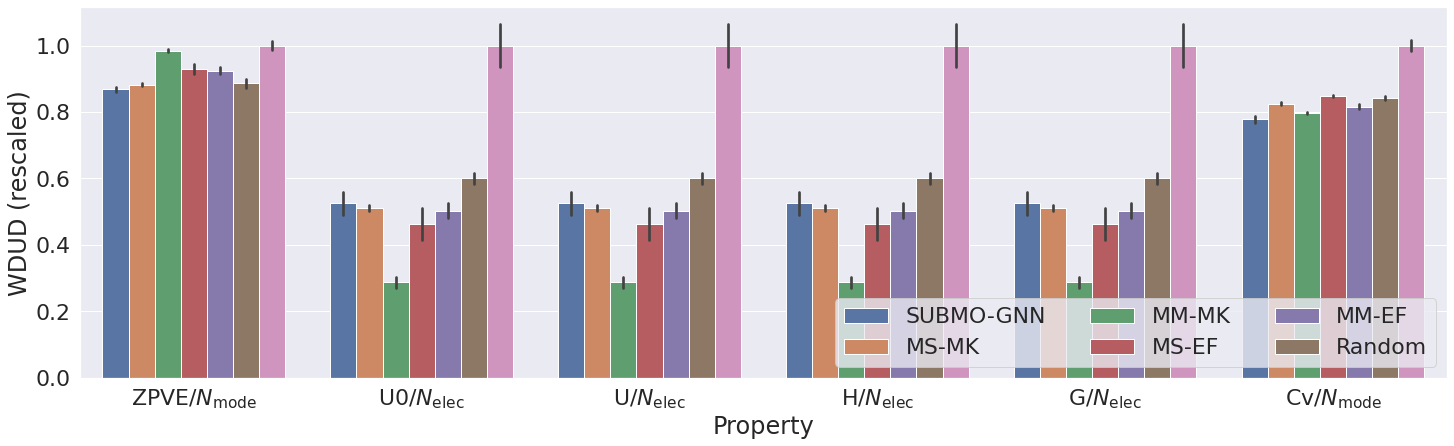

In [7]:
methods = ['logdet_ranking', 'logdet_ranking_normalize', 'maxsum_dissim_ranking', 'maxsum_dissim_ranking_normalize', 'maxmin_dissim_ranking', 'maxmin_dissim_ranking_normalize', 'random_ranking']
plotdf = wasserstein_distances[wasserstein_distances['method'].isin(methods)]

properties_lists = [
    ['mu', 'alpha', 'homo', 'lumo', 'gap', 'r2'],  
    ['zpve', 'u0', 'u298', 'h298', 'g298', 'cv'],  
    ['zpve/3n-6', 'u0/Nelec', 'u298/Nelec', 'h298/Nelec', 'g298/Nelec', 'cv/3n-6'],  
]

property_labels_lists = [
    ['mu', 'alpha', 'HOMO', 'LUMO', 'gap', 'R2'],  
    ['ZPVE', 'U0', 'U', 'H', 'G', 'Cv'],  
    [r'ZPVE/$N_{\rm mode}$', r'U0/$N_{\rm elec}$', r'U/$N_{\rm elec}$', r'H/$N_{\rm elec}$', r'G/$N_{\rm elec}$', r'Cv/$N_{\rm mode}$'],  
]

for i in range(3):
    properties = properties_lists[i]
    property_labels = property_labels_lists[i]
    plotdf_i = plotdf[plotdf['property'].isin(properties)]

    plt.clf()
    plt.figure(figsize=(20, 6))
    ax = sns.barplot(x="property", y="scaled_distance", hue='method',hue_order=methods, ci='sd', data=plotdf_i)
    ax.set(ylabel='WDUD (rescaled)', xlabel='Property')
    ax.set_xticklabels(property_labels)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=main_method_labels, loc = 'lower right', ncol=3)
    sns.set(font_scale=2)
    plt.tight_layout(pad=0,w_pad=0, h_pad=0)
    plt.savefig('./evaluation/weval_ablation_{}.pdf'.format(i+1))
#plt.show()

# Histgram

In [27]:
properties = ['mu', 'homo', 'r2', 'u0', 'u0/Nelec']
properties_label = ['mu (Debye)', 'HOMO (Hartree)',r'R2 (Bohr${}^2$)', 'U0 (Hartree)', r'U0/$N_{\rm elec}$ (Hartree)']
methods = ['logdet_ranking_normalize', 'maxsum_dissim_ranking_maccs', 'random_ranking']
methods_label = ['SUBMO-GNN', 'MS-MK', 'Random']

select_num = int(len(df['qm9']['_1'])*0.01)
max_dict = {}
min_dict = {}
for prop in properties:
    max_dict[prop] = df['qm9']['_1'][prop].max()
    min_dict[prop] = df['qm9']['_1'][prop].min()

/home/sakaue/.pyenv/versions/anaconda3-5.3.1/envs/my-rdkit-env/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Figure size 432x288 with 0 Axes>

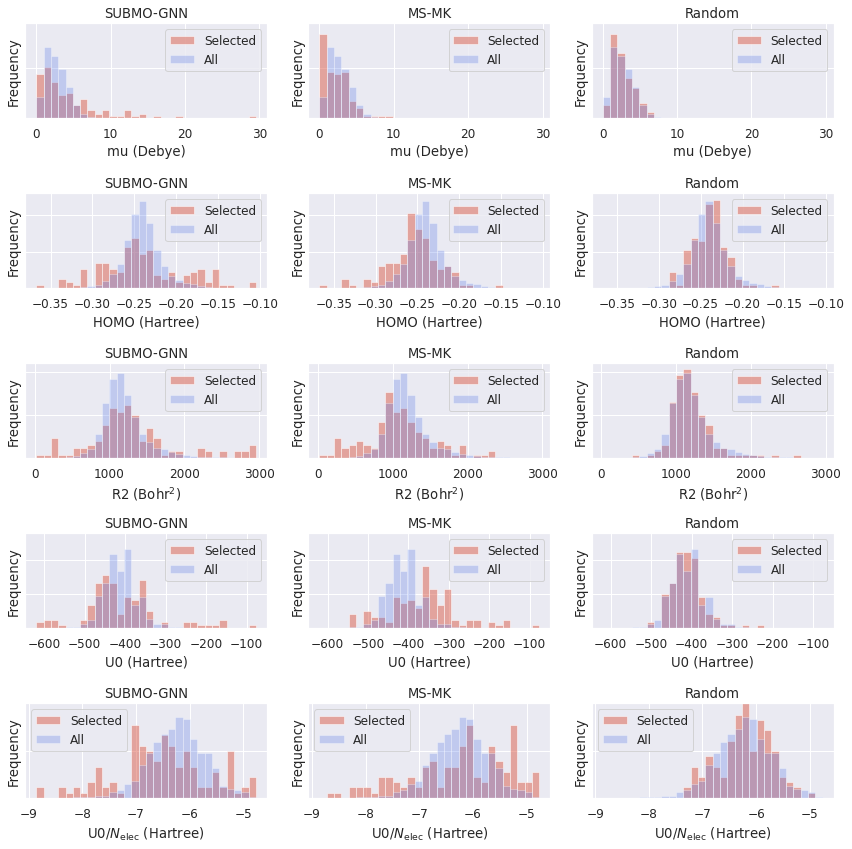

In [30]:
plt.clf()
sns.set(font_scale=1.1)
fig, axs = plt.subplots(len(properties), len(methods), figsize=(12, 12))

for i in range(len(methods)):
    if 'normalize' in methods[i]:
        selected = df['qm9_normalize']['_1'].sort_values(methods[i][:-10])[:select_num]
    else: 
        selected = df['qm9']['_1'].sort_values(methods[i])[:select_num]

    for j in range(len(properties)):
        sns.distplot(selected[properties[j]], bins=30, norm_hist=True, label='Selected', kde=False, ax=axs[j, i], 
                    hist_kws={"range": [min_dict[properties[j]], max_dict[properties[j]]], "alpha": 0.5, 
                              "color": sns.color_palette("coolwarm", 24)[21]}
                    )
        sns.distplot(df['qm9']['_1'][properties[j]], bins=30, norm_hist=True, label="All", kde=False, ax=axs[j, i], 
                    hist_kws={"range": [min_dict[properties[j]], max_dict[properties[j]]],  "alpha": 0.3, 
                              "color": sns.color_palette("coolwarm", 24)[2]} 
                    )

fig.subplots_adjust(hspace=0.4, wspace=0.2)
for i in range(len(methods)):
    for j in range(len(properties)):
        axs[j,i].set_title(methods_label[i])
        # axs[j,i].set_xlabel(properties_label[j], fontsize=10)
        axs[j,i].set_xlabel(properties_label[j])
        # axs[j,i].set_ylabel('frequency', fontsize=10)
        axs[j,i].set_ylabel('Frequency')
        axs[j,i].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
        axs[j,i].legend()

for i in range(len(methods)):
    for j in range(len(properties)):
        if j == 0:
            axs[j,i].set_ylim(0,.38)
        elif j == 1:
            axs[j,i].set_ylim(0,26)
        elif j == 2:
            axs[j,i].set_ylim(0,.0022)
        elif j == 3:
            axs[j,i].set_ylim(0,.014)
        else:
            axs[j,i].set_ylim(0, 1)

#fig.show()
#plt.tight_layout(pad=0,w_pad=0, h_pad=0)
plt.tight_layout()
plt.savefig('hist_qm9_perelec.pdf')

# Caluculate MPD

In [31]:
mpds = pd.DataFrame([])

gnn_based = ['logdet_ranking', 'maxsum_dissim_ranking', 'maxmin_dissim_ranking', 'random_ranking']
binary_based = ['maxsum_dissim_ranking_maccs', 'maxmin_dissim_ranking_maccs', 'maxsum_dissim_ranking_ecfp', 'maxmin_dissim_ranking_ecfp']

mpds = pd.concat([mpds, dfs2mpd(df['qm9'], gnn_based, n_select)])

mpd = dfs2mpd(df['qm9_normalize'], gnn_based, n_select)
mpd['method'] = mpd['method'].apply(lambda x: x+'_normalize')
mpds = pd.concat([mpds, mpd])

mpds = pd.concat([mpds, dfs2mpd(df['qm9'], binary_based, n_select)])

In [32]:
pickle.dump(mpds, open( "./evaluation/mpd_values.p", "wb" ))

df_mean = mpds.groupby(['method', 'fingerprint']).mean()
df_mean.to_csv("./evaluation/mpd_mean.csv")

df_std = mpds.groupby(['method', 'fingerprint']).std()
df_std.to_csv("./evaluation/mpd_std.csv")

# Barplot MPD

In [33]:
from matplotlib import pyplot as plt 
import seaborn as sns
import pickle

with open('./evaluation/mpd_values.p', 'rb') as f:
    mpds = pickle.load(f)

<Figure size 432x288 with 0 Axes>

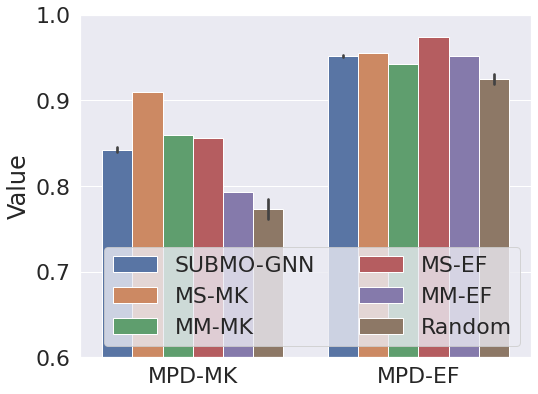

In [35]:
methods = ['logdet_ranking_normalize', 'maxsum_dissim_ranking_maccs', 'maxmin_dissim_ranking_maccs', 'maxsum_dissim_ranking_ecfp', 'maxmin_dissim_ranking_ecfp', 'random_ranking']
main_method_labels = ['SUBMO-GNN', 'MS-MK', 'MM-MK', 'MS-EF', 'MM-EF', 'Random']
plotdf = mpds[mpds['method'].isin(methods)]


plt.clf()
plt.figure(figsize=(8, 6))
ax = sns.barplot(x="fingerprint", y="mpd", hue='method',hue_order=methods, ci='sd', data=plotdf)
ax.set(ylabel='Value', xlabel='')
ax.set_xticklabels(['MPD-MK', 'MPD-EF'])
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=main_method_labels, loc = 'lower right', ncol=2)
plt.ylim([.6, 1])
sns.set(font_scale=2)
#plt.tight_layout(pad=0,w_pad=0, h_pad=0)
plt.tight_layout()
plt.savefig('./evaluation/mpd_eval.pdf')
#plt.show()